# Stock market prediction from daily news


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import nltk

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC, LinearSVC
from sklearn import tree
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

from keras.models import Sequential

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stocknews/RedditNews.csv
/kaggle/input/stocknews/upload_DJIA_table.csv
/kaggle/input/stocknews/Combined_News_DJIA.csv


# Inspect and prepairing Dataset

Load the dataset and have a first impression of the data.

The file consists of the Top25 news headline per day and a label with only two values: 
- "1" when DJIA Adj Close value rose or stayed the same
- "0" when DJIA Adj Close value decreased

In [2]:
data = pd.read_csv('/kaggle/input/stocknews/Combined_News_DJIA.csv')
data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

First, all headlines are merged into one column

In [3]:
data['headlines'] = data[data.columns[2:]].apply(lambda x: '. '.join(x.dropna().astype(str)),axis=1)

Histogram of the length of the headlines

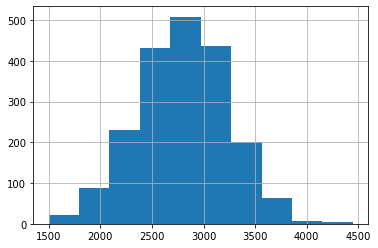

In [4]:
data['comment_length'] = data['headlines'].apply(lambda x : len(x))
data['comment_length'].hist()

Distribution of labels

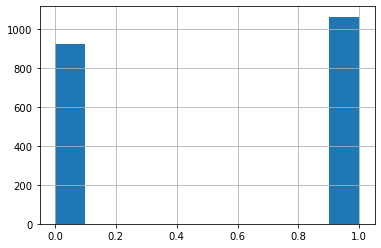

In [5]:
data['Label'].hist()

Split the data into train and test set. As proposed, the data until 31.12.2014 is used as training set and the following two years as test set. This is roughly a 80%/20% split.

In [6]:
train = data[data['Date'] < '2015-01-01']
test = data[data['Date'] > '2014-12-31']

# First attempt with Tf-idf and simple Classifier

Starting from the daily headlines, the sentences were tokenized into words by using the RegexpTokenizer of nltk. Lemmatisation is also applied. The following CustomTokenizer takes over this task.

In [7]:
nltk.download('stopwords', quiet=True, raise_on_error=True)
stop_words_en = set(nltk.corpus.stopwords.words('english'))
stop_words_en.add("b")

class CustomTokenizer:
    
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
        
    def _lem(self, token):
        if (token in stop_words_en):
            return token  # Solves error "UserWarning: Your stop_words may be inconsistent with your preprocessing."
        return self.wnl.lemmatize(token)
    
    def __call__(self, doc):
        return [self._lem(t) for t in self.tokenizer.tokenize(doc)]

Using the CustomTokenizer, the TfidfVectorizer convert the collection of raw headlines to a matrix of TF-IDF features.
- English stopwords are removed, all words are converted to lowercase
- With ngram_range=(2,2) only word-tuples are considered
- min_df and max_df ignore terms that have a document frequency strictly lower/higher than the given threshold (in percent)

For fitting the vectorizer, only the training set is used. 

In [8]:
vectorizer = CountVectorizer(tokenizer=CustomTokenizer(), stop_words=stop_words_en, lowercase=True, min_df=0.0075,  max_df=0.05, ngram_range=(2,2))

features_train = vectorizer.fit_transform(train['headlines'].tolist())
features_test = vectorizer.transform(test['headlines'].tolist())

Inspect the feature names and the TF-IDF features

In [9]:
feature_names = vectorizer.get_feature_names()
print(feature_names[50:100])

X_train = pd.DataFrame(features_train.todense(), columns = feature_names)
X_test = pd.DataFrame(features_test.todense(), columns = feature_names)

X_train.head()

['250 000', '3 000', '3 billion', '3 day', '3 million', '3 year', '30 000', '30 million', '30 year', '300 000', '300 million', '4 000', '4 5', '4 billion', '4 day', '4 million', '4 year', '40 000', '40 year', '48 hour', '5 000', '5 billion', '5 million', '5 year', '50 000', '50 million', '50 year', '500 000', '500 year', '6 000', '6 billion', '6 million', '6 month', '60 000', '60 year', '7 billion', '7 year', '70 000', '70 percent', '8 000', '8 year', '9 11', '9 year', 'abc news', 'abuse scandal', 'according new', 'according report', 'accuses u', 'acid attack', 'across country']


,000 000,000 dead,000 euro,000 troop,000 year,1 2,1 3,1 4,1 5,1 500,...,year since,year u,year world,york time,young child,young girl,young men,young people,young woman,yr old
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [10]:
from collections import defaultdict

up_unigrams = defaultdict(int)
down_unigrams = defaultdict(int)

for word in feature_names:
    up_unigrams[word] += np.sum(X_train[train['Label']==1][word])
    down_unigrams[word] += np.sum(X_train[train['Label']==0][word])
        
df_up_unigrams = pd.DataFrame(sorted(up_unigrams.items(), key=lambda x: x[1])[::-1])
df_down_unigrams = pd.DataFrame(sorted(down_unigrams.items(), key=lambda x: x[1])[::-1])
df_up_unigrams.head()

,0,1
0,islamic state,73
1,world cup,60
2,bin laden,51
3,supreme court,50
4,right group,50


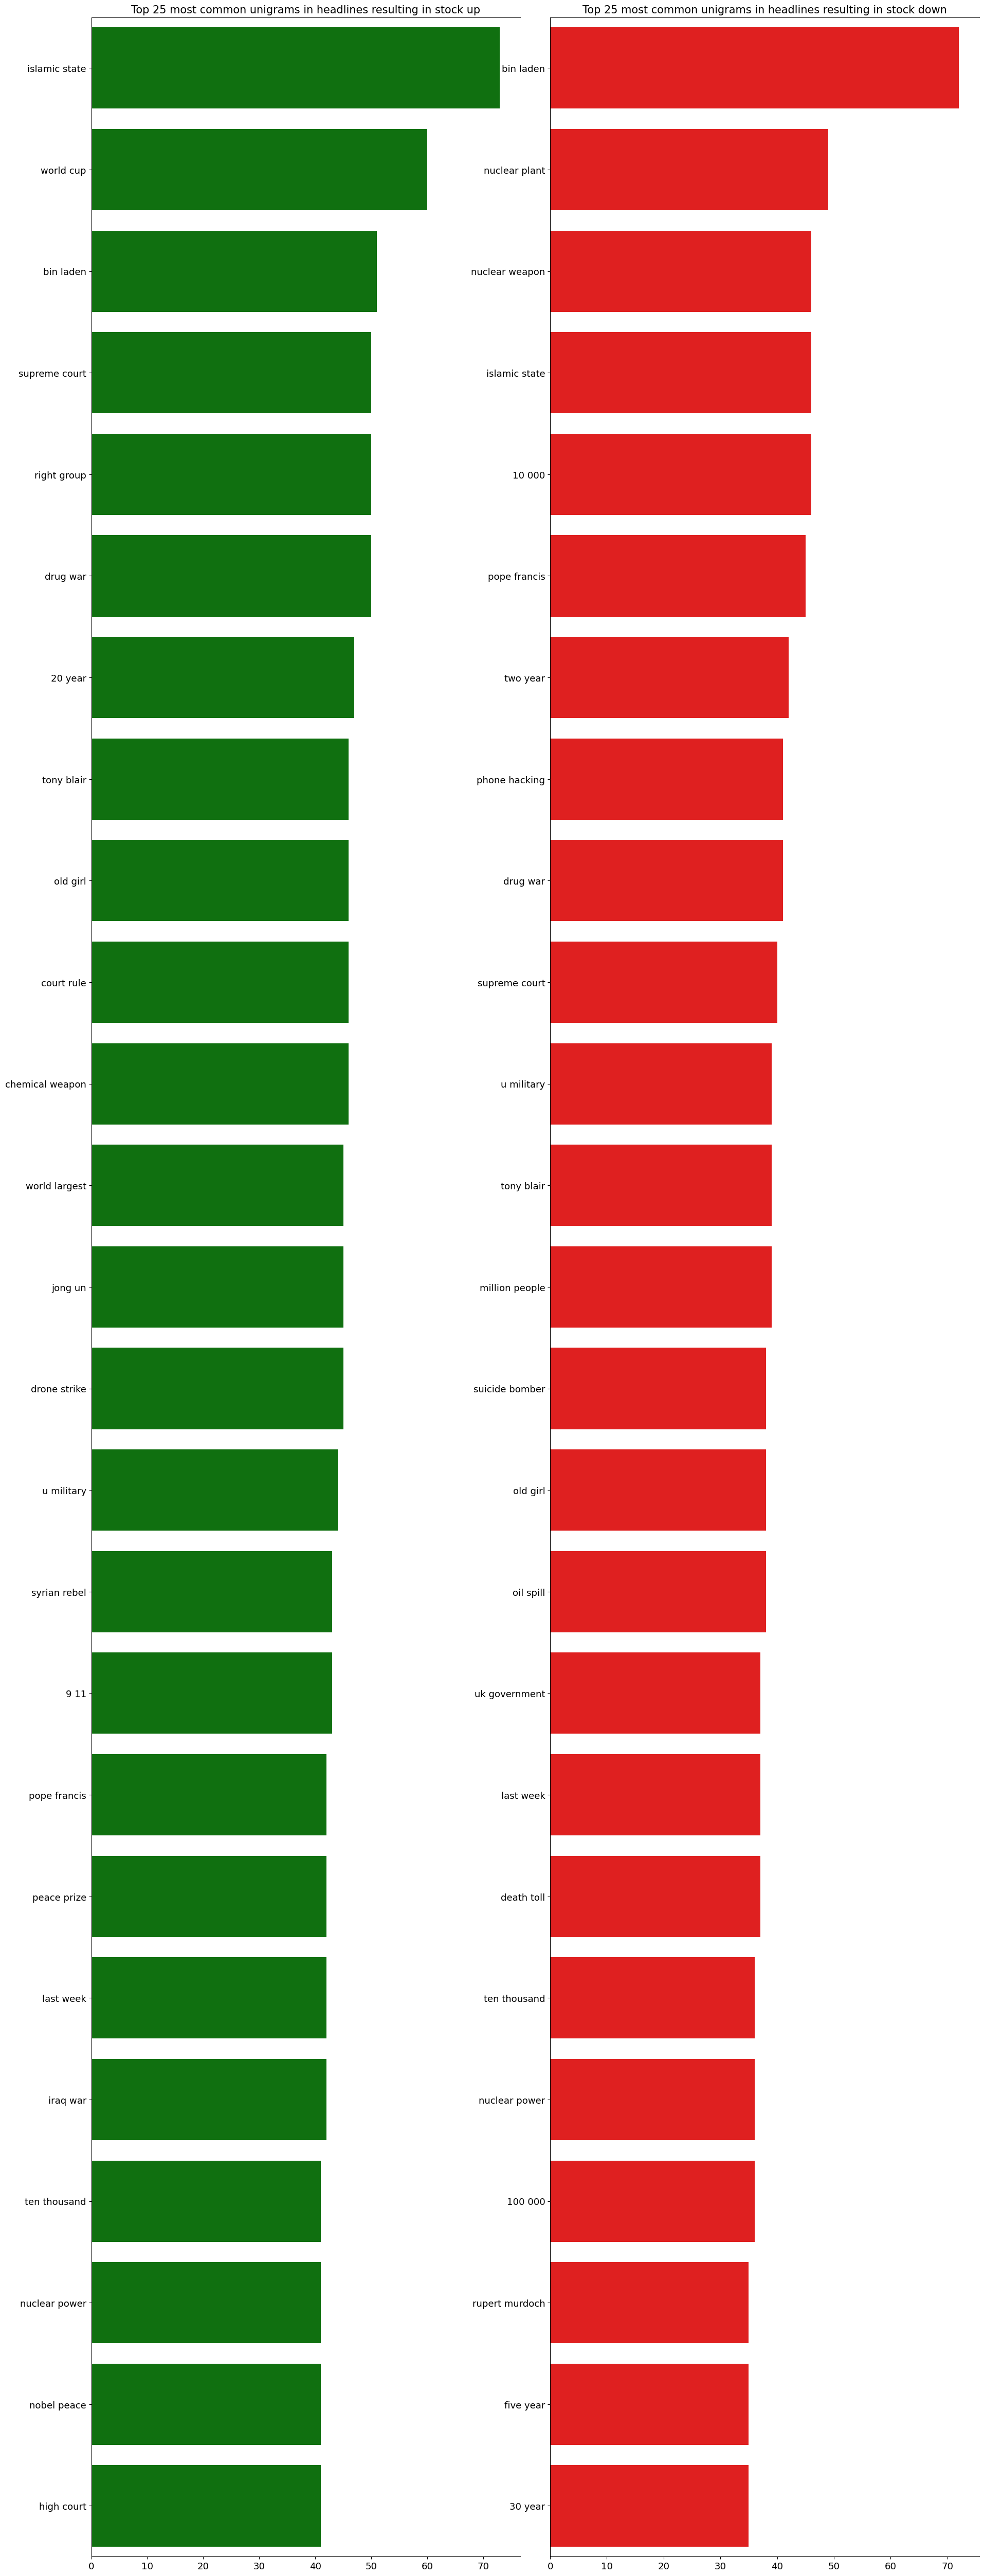

In [11]:
import seaborn as sns

N=25

fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_up_unigrams[0].values[:N], x=df_up_unigrams[1].values[:N], ax=axes[0], color='green')
sns.barplot(y=df_down_unigrams[0].values[:N], x=df_down_unigrams[1].values[:N], ax=axes[1], color='red')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in headlines resulting in stock up', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in headlines resulting in stock down', fontsize=15)

plt.show()

Use SVC Classifier to predict testdata

In [12]:
clf = SVC()
clf = clf.fit(X_train, train["Label"].tolist())
print('Accuracy X_train: ' + str(clf.score(X_train, train["Label"].tolist())))

predictions = clf.predict(X_test)

pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])

Accuracy X_train: 0.9621353196772191


Predicted,0,1
Actual,,
0,36,150
1,30,162


In [13]:
print (classification_report(test["Label"], predictions))
print ('Accuracy X_test: ' + str(accuracy_score(test["Label"], predictions)))

              precision    recall  f1-score   support

           0       0.55      0.19      0.29       186
           1       0.52      0.84      0.64       192

    accuracy                           0.52       378
   macro avg       0.53      0.52      0.46       378
weighted avg       0.53      0.52      0.47       378

Accuracy X_test: 0.5238095238095238


# Keras Sequential model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 9760      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 18        
Total params: 9,778
Trainable params: 9,778
Non-trainable params: 0
_________________________________________________________________
None


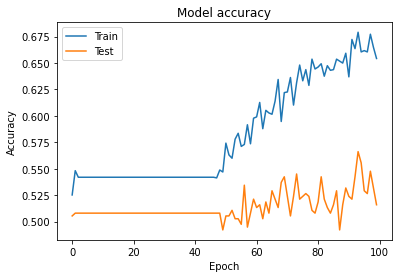

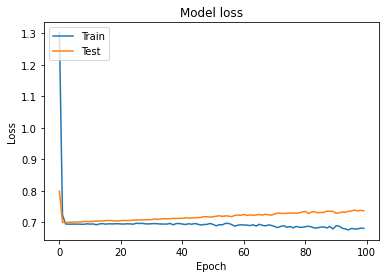

12/12 [==============================] - 0s 1ms/step - loss: 0.7363 - accuracy: 0.5159
[0.7362737655639648, 0.5158730149269104]


In [14]:
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adadelta,Adam,RMSprop
from keras.utils import np_utils
from keras import Sequential, optimizers, regularizers

scale = np.max(X_train)
X_train /= scale
X_test /= scale

mean = np.mean(X_train)
X_train -= mean
X_test -= mean

num_features = X_train.shape[1]

model = Sequential()
model.add(Dense(8,input_shape=(num_features,), activation='relu', kernel_regularizer = regularizers.l2(0.1)))
model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.001)))
#model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.0001)))
#model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.1)))
#model.add(Dropout(0.5))
#model.add(Dense(128, activation='relu', kernel_regularizer = regularizers.l2(0.001)))
#model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Y_train = np_utils.to_categorical(train["Label"], 2)
Y_test = np_utils.to_categorical(test["Label"], 2)

history = model.fit(X_train, Y_train, batch_size=32, validation_data=(X_test, Y_test), epochs=100, verbose=0)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
    
score = model.evaluate(X_test, Y_test)
print(score)

# Use Word2Vec

Use Word2Vec to find most similar words

In [15]:
class MyTokenizer():
    def __init__(self):
        self.tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
        self.lemmatizer = nltk.stem.WordNetLemmatizer()
        self.stop_words_en = set(nltk.corpus.stopwords.words('english'))
        self.stop_words_germ = set(nltk.corpus.stopwords.words('german'))
        self.stop_words = set()
        self.stop_words.add("b")
        
    def tokenize(self, headlines):
        # Tokenize
        tokens = [self.tokenizer.tokenize(article) for article in headlines]

        # Lemmatizer
        clean_tokens = []
        for words in tokens:
            clean_tokens.append([self.lemmatizer.lemmatize(word) for word in words])

        # Stop words
        final_tokens = []
        for words in clean_tokens:
            final_tokens.append([word.lower() for word in words if word.lower() not in self.stop_words_en and word.lower() not in self.stop_words_germ and word.lower() not in self.stop_words])
            
        return final_tokens

In [16]:
from gensim.models import Word2Vec

tokenizer = MyTokenizer()

headlines_train = train["headlines"]
headlines_test= test["headlines"]

tokens_train = tokenizer.tokenize(headlines_train)
tokens_test = tokenizer.tokenize(headlines_test)

model = Word2Vec(tokens_train, min_count=1,size= 50,workers=3, window =3, sg = 1)

word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

print(model.wv.most_similar('husband'))

Number of word vectors: 29909
[('repeatedly', 0.9811447858810425), ('abusing', 0.9789028167724609), ('assaulted', 0.9765592813491821), ('murdering', 0.9754806756973267), ('minor', 0.9729715585708618), ('hanged', 0.9704235792160034), ('falsely', 0.9693689346313477), ('father', 0.9692800641059875), ('attempted', 0.9684377908706665), ('beheaded', 0.9683940410614014)]


# Word embedding

Number of words: 20000
max_length: 200
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 16)           320000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 320,978
Trainable params: 320,978
Non-trainable params: 0
_________________________________________________________________
None


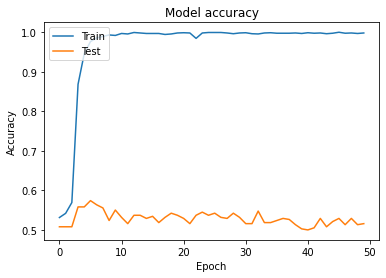

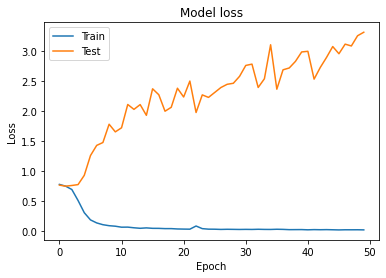

12/12 [==============================] - 0s 21ms/step - loss: 3.3165 - accuracy: 0.5159
Testing Accuracy is 51.58730149269104 


In [17]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.layers import Flatten, Dense, LSTM, GRU, SpatialDropout1D, Bidirectional, concatenate
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import SGD

my_tokenizer = MyTokenizer()

headlines_train = train["headlines"]
headlines_test= test["headlines"]
tokens_train = my_tokenizer.tokenize(headlines_train)
tokens_test = my_tokenizer.tokenize(headlines_test)

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train["headlines"])
        
vocab_size = 20000 #len(tokenizer.word_index) + 1
print('Number of words: ' + str(vocab_size))

X_train_tokens = tokenizer.texts_to_sequences(tokens_train)
X_test_tokens = tokenizer.texts_to_sequences(tokens_test)

max_length = 0
for words in X_train_tokens:
    if len(words)>max_length:
        max_length = len(words)
max_length = 200
print('max_length: ' + str(max_length))

X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

y_train = train['Label']
y_test = test['Label']
Y_train = np_utils.to_categorical(y_train, 2)
Y_test = np_utils.to_categorical(y_test, 2)

model = Sequential()
model.add(Embedding(vocab_size, 16, input_length=max_length))
#model.add(SpatialDropout1D(0.5))
model.add(LSTM(8, dropout=0.2, recurrent_dropout=0.2)) 
#model.add(Bidirectional(LSTM(units=64, recurrent_dropout=0.5)))
#model.add(Flatten())
#model.add(Dense(32, activation='relu', kernel_regularizer = regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer = regularizers.l2(0.01)))
#model.add(Dropout(0.5))
#model.add(Dense(64, activation='relu', kernel_regularizer = regularizers.l2(0.001)))
#model.add(Dropout(0.5))
#model.add(GRU(units=32, dropout=0.5, recurrent_dropout=0.5))
#model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train_pad, Y_train, batch_size=32, epochs=50, verbose=0, validation_data=(X_test_pad, Y_test))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

loss, accuracy = model.evaluate(X_test_pad,Y_test)
print('Testing Accuracy is {} '.format(accuracy*100))

The accuracy is not so good. Only slightly better than guessing.